In [1]:
DATA_DIR="."
import warnings
warnings.filterwarnings("ignore") 
import os
import numpy as np
import pickle

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
#from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.sample(3)

,review,sentiment
37964,Bogmeister and others have pretty much nailed ...,positive
25019,My god ! Buttgereit's masterpiece is one of th...,positive
2824,The fact that there are positive comments abou...,negative


In [3]:
df.sentiment = df.sentiment.map({'negative': 0, 'positive': 1})

In [4]:
df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [5]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
# make some text cleaning
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

In [7]:
df['review'] = df['review'].apply(strip)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,Petter Mattei's Love in the Time of Money is a...,1


In [8]:
sentences = df['review']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]
sentence[13]

"[CLS] The cast played ShakespeareShakespeare lostI appreciate that this is trying to bring Shakespeare to the masses, but why ruin something so goodIs it because 'The Scottish Play' is my favorite Shakespeare I do not know What I do know is that a certain Rev Bowdler hence bowdlerization tried to do something similar in the Victorian eraIn other words, you cannot improve perfectionI have no more to write but as I have to write at least ten lines of text and English composition was never my forte I will just have to keep going and say that this movie, as the saying goes, just does not cut it [SEP]"

In [9]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'", 'll', 'be', 'hooked', 'they', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'met', '##he', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'un', '##fl', '##in', '##ching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'tim', '##id', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '##it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'pen', '##ite', '##nta', '##ry', 'it', 'focuses', 'mainl

In [10]:
labels = list(df['sentiment'])

In [11]:
def add_sep_token(x):
    x[-1] = 102
    return x

In [12]:
# Set the maximum sequence length. 
MAX_LEN = 128

id_seq = [torch.LongTensor(tokenizer.convert_tokens_to_ids(tokens[:MAX_LEN])) 
          for tokens in tokenized_texts]
id_seq = list(map(add_sep_token, id_seq))
# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequence(id_seq, batch_first=True)
input_ids.size()

torch.Size([50000, 128])

In [13]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [14]:
# Select a batch size for training. 
batch_size = 64

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) #binary classification
model.cuda();

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.29831883213906124


Epoch:  25%|██▌       | 1/4 [10:06<30:19, 606.43s/it]

Validation Accuracy: 0.8947784810126582
Train loss: 0.1556740683921486


Epoch:  50%|█████     | 2/4 [20:10<20:10, 605.21s/it]

Validation Accuracy: 0.8939873417721519
Train loss: 0.07133542507852492


Epoch:  75%|███████▌  | 3/4 [30:18<10:06, 606.45s/it]

Validation Accuracy: 0.8971518987341772
Train loss: 0.03672954366613174


Epoch: 100%|██████████| 4/4 [40:22<00:00, 605.64s/it]

Validation Accuracy: 0.8999208860759493


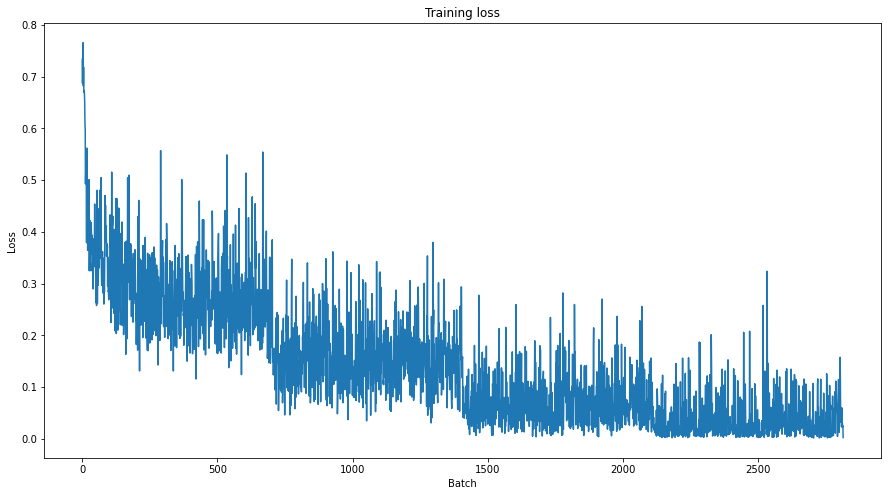

In [16]:
from tqdm import tqdm, trange
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
    model.train()  
  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
      # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
      # Backward pass
        loss.backward()
      # Update parameters and take a step using the computed gradient
        optimizer.step()
      # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
    model.eval()
  # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
    for batch in validation_dataloader:
      # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
        # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()